# Flower Image Classifier 

In this project, I trained an image classifier to recognize different species of flowers.The data is from [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories.

In [1]:
# Imports here
import torch
from torchvision import datasets, transforms,models
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Load the data

I used `torchvision` to load the data. The dataset is split into three parts, training, validation, and testing. For the training, I applied transformations such as cropping, and flipping to help the network generalize. I also resized the input data to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. I also resized then cropped the images to the appropriate size.

The pre-trained networks I used were trained on the ImageNet dataset where each color channel was normalized separately. So I normalized the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(40),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir,transform =train_transforms)
validation_data = datasets.ImageFolder(valid_dir,transform =test_transforms)
test_data = datasets.ImageFolder(test_dir,transform =test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(validation_data,batch_size=64)
testloader = torch.utils.data.DataLoader(test_data,batch_size=64)

### Label mapping

Loaded in a mapping from category label to category name. 

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

In [5]:
#import pre-trained model
model = models.vgg19(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:41<00:00, 13883515.73it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [7]:
# freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# build new classifier
classifier = nn.Sequential(nn.Linear(25088, 1024),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(512, 102),
                           nn.LogSoftmax(dim=1))

# assign new classifier to model
model.classifier =classifier

# using GPU mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [9]:
# define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [10]:
#training model
epochs = 5
steps = 0
running_loss = 0
print_every = 20

for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)
    steps += 1
        
    optimizer.zero_grad()
    logps = model.forward(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss
        
    if steps % print_every == 0:
        valid_loss = 0
        valid_accuracy = 0
        model.eval()
            
        with torch.no_grad():
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model.forward(images)
                batch_loss = criterion(logps, labels)
                    
                valid_loss += batch_loss
                    
                # Calculate accuracy
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                valid_accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
        print(f"Epoch {i+1}/{epochs}.. "
                f"Train loss: {running_loss/print_every:.3f}.. "
                f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                f"Validation accuracy: {valid_accuracy/len(validloader):.3f}")
        running_loss = 0
        model.train()

Epoch 1/5.. Train loss: 4.279.. Validation loss: 3.368.. Validation accuracy: 0.224
Epoch 1/5.. Train loss: 3.314.. Validation loss: 2.325.. Validation accuracy: 0.435
Epoch 1/5.. Train loss: 2.554.. Validation loss: 1.720.. Validation accuracy: 0.549
Epoch 1/5.. Train loss: 2.159.. Validation loss: 1.426.. Validation accuracy: 0.610
Epoch 1/5.. Train loss: 1.898.. Validation loss: 1.170.. Validation accuracy: 0.693
Epoch 2/5.. Train loss: 1.674.. Validation loss: 1.008.. Validation accuracy: 0.703
Epoch 2/5.. Train loss: 1.534.. Validation loss: 0.934.. Validation accuracy: 0.750
Epoch 2/5.. Train loss: 1.512.. Validation loss: 0.871.. Validation accuracy: 0.749
Epoch 2/5.. Train loss: 1.442.. Validation loss: 0.865.. Validation accuracy: 0.744
Epoch 2/5.. Train loss: 1.366.. Validation loss: 0.837.. Validation accuracy: 0.759
Epoch 3/5.. Train loss: 1.251.. Validation loss: 0.792.. Validation accuracy: 0.777
Epoch 3/5.. Train loss: 1.178.. Validation loss: 0.711.. Validation accuracy

## Testing your network

Run the test images through the network and measure the accuracy

In [11]:
model.eval()
test_loss=0
test_accuracy=0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        logps = model.forward(images)
        loss = criterion(logps, labels)
                   
        test_loss += loss
                    
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
    print(f"Test loss: {test_loss/len(testloader):.3f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.3f}")

Test loss: 0.619.. Test accuracy: 0.821


## Save the checkpoint

In [12]:
# map classes to indices
model.class_to_idx = train_data.class_to_idx

# save important features
torch.save({
            'epochs': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'class_idx':model.class_to_idx,
            'classifier':model.classifier,
            }, 'checkpoint.pth')

## Loading the checkpoint
write a function that can load a checkpoint and rebuild the model

In [13]:
def load_checkpoint(filepath):
    # load checkpoint file
    checkpoint = torch.load(filepath)
    
    # initialize the model
    model = models.vgg19(pretrained=True)
    # define classifier
    model.classifier=checkpoint['classifier']
    # store mapping from class to index
    model.class_to_idx=checkpoint['class_idx']
    # load model state 
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # define optimizer and load state
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    #retrieve epochs
    epochs = checkpoint['epochs']
    
    return model

# Inference for classification

## Image Preprocessing

In [14]:
# Process a PIL image for use in a PyTorch model
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    im = Image.open(image)
    #resize image
    im.thumbnail([256,256])
    #center crop image and normalize
    transform = transforms.CenterCrop(224)
    im = transform(im)
    # convert color channels
    np_image = np.asarray(im)/256
    # normalize numpy array
    np_image = (np_image-[0.485, 0.456, 0.406])/ [0.229, 0.224, 0.225]
    # change color chanel to first dimension
    np_image = np_image.transpose(2,0,1) 
    #create tensor
    image_tensor = torch.from_numpy(np_image)
    
    return image_tensor

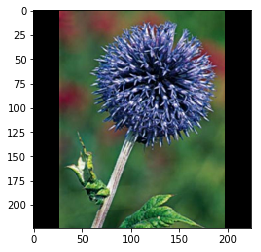

In [15]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose(1, 2, 0)
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std* image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    return ax

imshow(process_image('flowers/train/10/image_07088.jpg'))

## Class Prediction

Predict the top 5 most probable classes. 

In [16]:
class_idx =train_data.class_to_idx
idx_class= dict(map(reversed, class_idx.items()))

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image=process_image(image_path)
    image.unsqueeze_(0)
    model.eval()
    with torch.no_grad():
        image = image.type(torch.FloatTensor)
        image=image.cuda()
        logps = model.forward(image)
        ps = torch.exp(logps)
        top_p, top_idx = ps.topk(5)
        top_class = [idx_class[i] for i in top_idx.tolist()[0]]
    return top_p.tolist()[0],top_class

In [17]:
probs,classes = predict('flowers/train/10/image_07088.jpg', model)
print(probs)
print(classes)

[0.83360356092453, 0.11653197556734085, 0.04851840063929558, 0.0010859840549528599, 0.0001016328897094354]
['10', '35', '14', '17', '38']


## Sanity Checking

Use a trained model for predictions

In [18]:
# get flower name
cat_to_name['10']

'globe thistle'

In [19]:
# build function for processing image to show in subplot
def process(image):
    im = Image.open(image)
    im.thumbnail([256,256])
    transform = transforms.CenterCrop(224)
    im = transform(im)
    im = np.asarray(im)/256
    
    return im

[Text(0,0,'globe thistle'),
 Text(0,0,'alpine sea holly'),
 Text(0,0,'spear thistle'),
 Text(0,0,'purple coneflower'),
 Text(0,0,'great masterwort')]

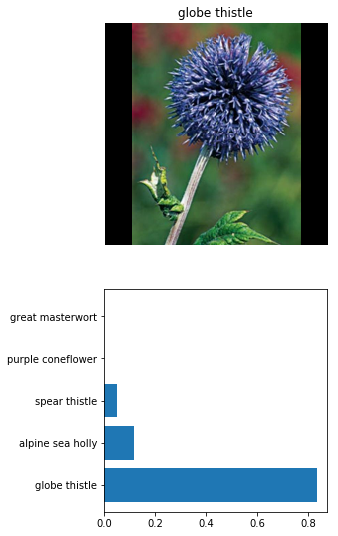

In [20]:
cat = [cat_to_name[i] for i in classes]
fig, (ax1, ax2) = plt.subplots(figsize=(4,9), nrows=2)
ax1.imshow(process('flowers/train/10/image_07088.jpg'))
ax1.set_title('globe thistle')
ax1.axis('off')
y_pos = np.arange(len(cat))
ax2.barh(y_pos, probs, align='center')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(cat)